In [44]:
'''This jupyter notebook will evaluate the correlation between parameters in the calvetti model as inferred in PMCMC.'''

'This jupyter notebook will evaluate the correlation between parameters in the calvetti model as inferred in PMCMC.'

In [45]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle
from particle_filter import pf_validator
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf,poisson_logpmf
from scipy.spatial import KDTree

In [46]:
def SEIR_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,eta = model_params

    '''OU Process'''
    sig = 1.0
    mu = -2.0
    lam = 1/100

    state_diff = 0.01 

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_E = (particles[index,4,t] * (particles[index, 1, t] + 0.1 * particles[index, 2, t]) * particles[index, 0, t])/np.sum(particles[index,:,t]) * dt
        new_E = np.exp(np.log(new_E) + state_diff/np.sum(particles[index,:,t]) * rng.normal(0,np.sqrt(dt)))

        new_I = (eta * particles[index,1,t]) * dt
        new_I = np.exp(np.log(new_I) + state_diff * rng.normal(0,np.sqrt(dt)))

        new_ER = (gamma * particles[index,1,t]) * dt
        new_ER = np.exp(np.log(new_ER) + state_diff * rng.normal(0,np.sqrt(dt)))

        new_IR = (gamma * particles[index,2,t]) * dt
        new_IR = np.exp(np.log(new_IR) + state_diff * rng.normal(0,np.sqrt(dt)))

        new_D = (0.004 * particles[index,2,t]) * dt
        new_D = np.exp(np.log(new_D) + state_diff * rng.normal(0,np.sqrt(dt)))

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_E) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_E - new_I - new_ER) #E
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_I - new_IR - new_D) #I
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_ER + new_IR) #R
        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal()) #beta

        observations[index,0,t] += new_I

    return particles,observations

def SEIR_Obs(data_point, particle_observations, model_params):
    weights = poisson_logpmf(data_point,particle_observations[:,0]+0.005)
    return weights

In [47]:
'''Import data sets'''

data = pd.read_csv('../data_sets/calvetti_data_17_09_2024.csv').to_numpy()
state = pd.read_csv('../data_sets/calvetti_state_17_09_2024.csv').to_numpy()

In [48]:
pmcmc_output = np.load('../pmcmc_output/calvetti_pmcmc_output.npz')

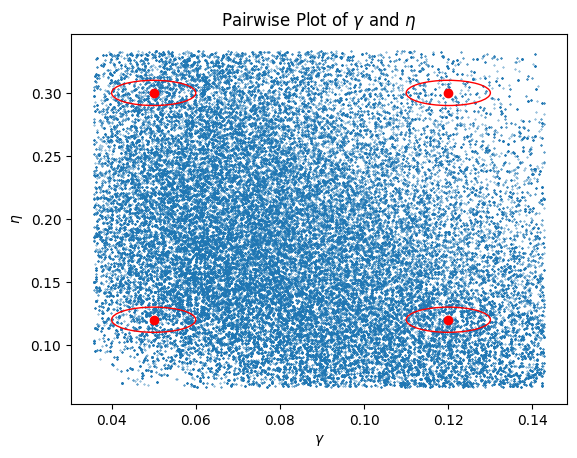

In [49]:
parameter_posterior = pmcmc_output['accepted_params']

burn_in = 1000

tuple_pos = np.array(list(set(zip(parameter_posterior[0,burn_in:],parameter_posterior[1,burn_in:]))))

tree = KDTree(tuple_pos)

epsilon_radius = 0.01
sample_points = [(0.05,0.12),(0.12,0.12),(0.12,0.3),(0.05,0.3)]

fig, ax = plt.subplots()
ax.set_title('Pairwise Plot of $\\gamma$ and $\\eta$')
ax.set_ylabel('$\\eta$')
ax.set_xlabel('$\\gamma$')
ax.scatter(parameter_posterior[0,burn_in:],parameter_posterior[1,burn_in:],s=0.1)
for point in sample_points:
    ax.scatter(*point,color = 'red')
    ax.add_patch(plt.Circle(point, epsilon_radius, color='r',fill=False))


In [50]:
def SEIR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    E_I_init = rng.integers(1,5,size = (num_particles,2))
    particles_0[:,0] -= np.sum(E_I_init,axis = 1)
    particles_0[:,1] = E_I_init[:,0]
    particles_0[:,2] = E_I_init[:,1]
    particles_0[:,4] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':1_000, 
                      'dt':0.1,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init,
                      }




Text(0.5, 1.0, 'Ball around (0.05, 0.12), Avg LL: -215.17490526689343')

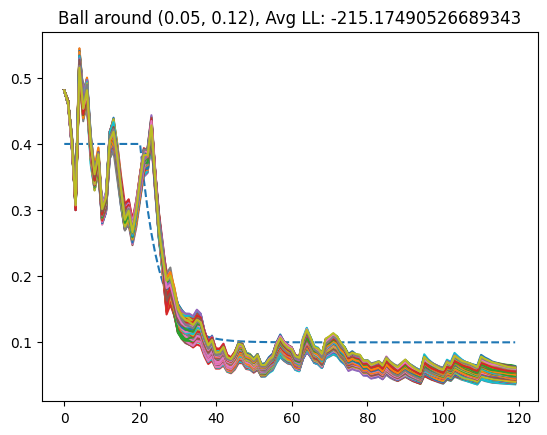

In [51]:

idx = tree.query_ball_point(sample_points[0],r=epsilon_radius)
samples = tuple_pos[idx]

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

beta_params = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_params,t) for t in t_vec])

plt.plot(betas,'--')
LL = []
for sample in samples: 
    distribution,_,_,pf_LL = p_filter(data = data,
        model_params= (sample[0],sample[1]),
        rng = np.random.default_rng(0)
        )
    LL.append(np.sum(pf_LL))

    plt.plot(np.mean(distribution[:,4,:],axis = 0))

plt.title(f'Ball around {sample_points[0]}, Avg LL: {np.mean(LL)}')
    


Text(0.5, 1.0, 'Ball around (0.12, 0.12), Avg LL: -214.93936101087175')

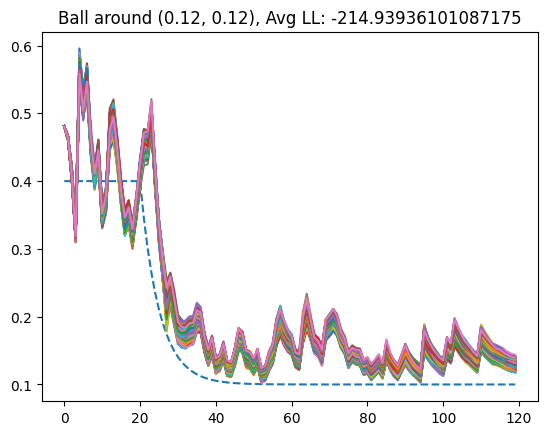

In [52]:

idx = tree.query_ball_point(sample_points[1],r=epsilon_radius)
samples = tuple_pos[idx]

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

beta_params = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_params,t) for t in t_vec])

plt.plot(betas,'--')
LL = []
for sample in samples: 
    distribution,_,_,pf_LL = p_filter(data = data,
        model_params= (sample[0],sample[1]),
        rng = np.random.default_rng(0)
        )
    LL.append(np.sum(pf_LL))

    plt.plot(np.mean(distribution[:,4,:],axis = 0))

plt.title(f'Ball around {sample_points[1]}, Avg LL: {np.mean(LL)}')

Text(0.5, 1.0, 'Ball around (0.12, 0.3), Avg LL: -216.71032776583635')

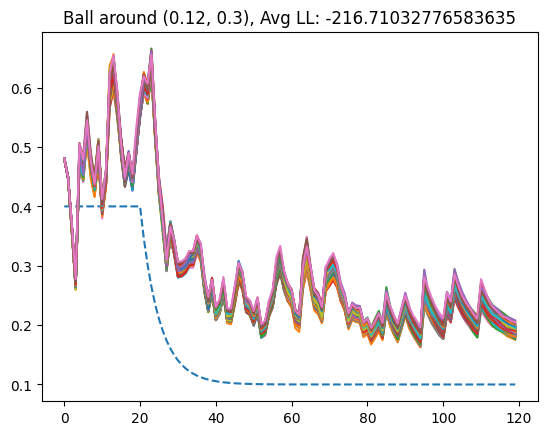

In [53]:

idx = tree.query_ball_point(sample_points[2],r=epsilon_radius)
samples = tuple_pos[idx]

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

beta_params = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_params,t) for t in t_vec])

plt.plot(betas,'--')
LL = []
for sample in samples: 
    distribution,_,_,pf_LL = p_filter(data = data,
        model_params= (sample[0],sample[1]),
        rng = np.random.default_rng(0)
        )
    LL.append(np.sum(pf_LL))

    plt.plot(np.mean(distribution[:,4,:],axis = 0))

plt.title(f'Ball around {sample_points[2]}, Avg LL: {np.mean(LL)}')

Text(0.5, 1.0, 'Ball around (0.05, 0.3), Avg LL: -215.38421808233923')

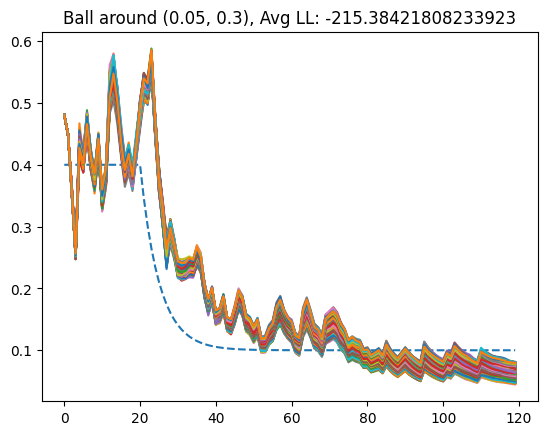

In [54]:

idx = tree.query_ball_point(sample_points[3],r=epsilon_radius)
samples = tuple_pos[idx]

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

beta_params = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_params,t) for t in t_vec])

plt.plot(betas,'--')
LL = []
for sample in samples: 
    distribution,_,_,pf_LL = p_filter(data = data,
        model_params= (sample[0],sample[1]),
        rng = np.random.default_rng(0)
        )
    LL.append(np.sum(pf_LL))

    plt.plot(np.mean(distribution[:,4,:],axis = 0))

plt.title(f'Ball around {sample_points[3]}, Avg LL: {np.mean(LL)}')